# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

In [1]:
# Imports here
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import torch
import torchvision
from torchvision import datasets, models, transforms
import torch.utils.data as data
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import time, os, copy, argparse
import multiprocessing
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
#from torch.utils.tensorboard import SummaryWriter
#from torchsummary import summary

%matplotlib inline

## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). The data should be included alongside this notebook, otherwise you can [download it here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz). 

If you do not find the `flowers/` dataset in the current directory, **/workspace/home/aipnd-project/**, you can download it using the following commands. 

```bash
!wget 'https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz'
!unlink flowers
!mkdir flowers && tar -xzf flower_data.tar.gz -C flowers
```


## Data Description
The dataset is split into three parts, training, validation, and testing. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. You'll also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks you'll use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.
 

In [2]:
data_dir = 'flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [3]:
# TODO: Define your transforms for the training, validation, and testing sets

data_transforms = transforms.Compose([transforms.Resize((224, 224)),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], 
                                                           [0.229, 0.224, 0.225])])

# TODO: Load the datasets with ImageFolder
image_datasets = { 'train': ImageFolder(root=train_dir, transform=data_transforms),
                   'val': ImageFolder(root=valid_dir, transform=data_transforms),
                  'test': ImageFolder(root=test_dir, transform=data_transforms)
                 }

# TODO: Using the image datasets and the trainforms, define the dataloaders

bs = 32                               # Batch size
num_classes = 102                     # Number of classes
num_cpu = 0                           # Number of workers

dataloaders = { 'train': DataLoader(image_datasets['train'], batch_size=bs, shuffle=True, 
                                         num_workers=num_cpu, pin_memory=True, drop_last=True),
                'val': DataLoader(image_datasets['val'], batch_size=bs, shuffle=True, 
                                         num_workers=num_cpu, pin_memory=True, drop_last=True),
               'test': DataLoader(image_datasets['test'], batch_size=bs, shuffle=True, 
                                         num_workers=num_cpu, pin_memory=True, drop_last=True)
              }

### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [4]:
import json

with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

### Data Exploration
 1. __Sample Images:__ Display a few sample images from each flower class to get a visual understanding of the different types of flowers present in the dataset.
 2. __Class Distribution:__ Visualize the distribution of flower classes in the dataset with a bar chart or pie chart showing the number of instances for each flower class. This will help to understand the class imbalance, if any.

#### Sample Images

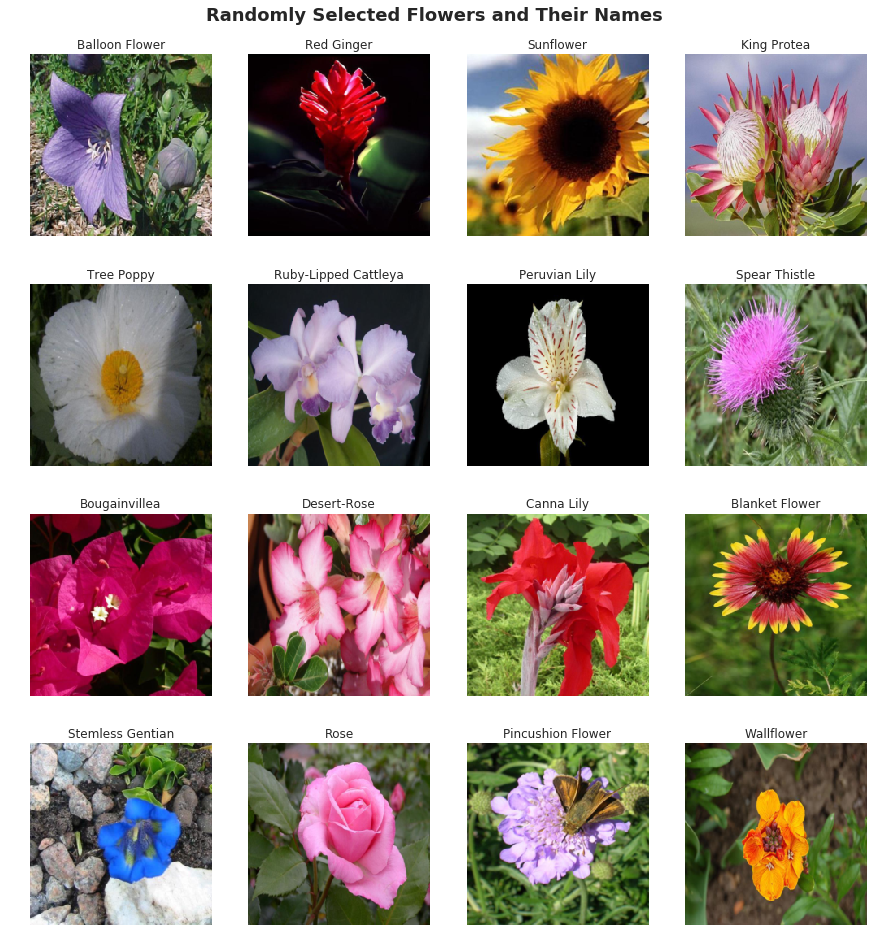

In [12]:
import random
from PIL import Image

# Get a list of subdirectories (flower species) in the train directory
flower_species = sorted(os.listdir(train_dir))

# Randomly select 16 images and their labels
selected_images = random.sample(flower_species, 16)

# Create a 4x4 grid for displaying the images
fig, axes = plt.subplots(4, 4, figsize=(15, 15))
axes = axes.flatten()

# Define the image transformation
image_transform = transforms.Compose([
    transforms.Resize((224, 224))
])

# Iterate over the selected images
for i, image_name in enumerate(selected_images):
    # Get the path to the image file
    image_path = os.path.join(train_dir, image_name, random.choice(os.listdir(os.path.join(train_dir, image_name))))

    # Open and transform the image
    image = Image.open(image_path)
    image = image_transform(image)

    # Display the transformed image
    axes[i].imshow(image)
    axes[i].axis('off')

    # Get the flower name associated with the image
    flower_name = cat_to_name[image_name]

    # Capitalize the first letter of each word in the flower name
    flower_name = flower_name.title()

    # Set the title of the subplot as the flower name
    axes[i].set_title(flower_name)

# Adjust the spacing between the subplots and the figure title
plt.subplots_adjust(top=0.94)

# Set the title of the figure
fig.suptitle("Randomly Selected Flowers and Their Names", fontsize=18, fontweight='bold')

# Show the plot
plt.show()

#### Class Distribution

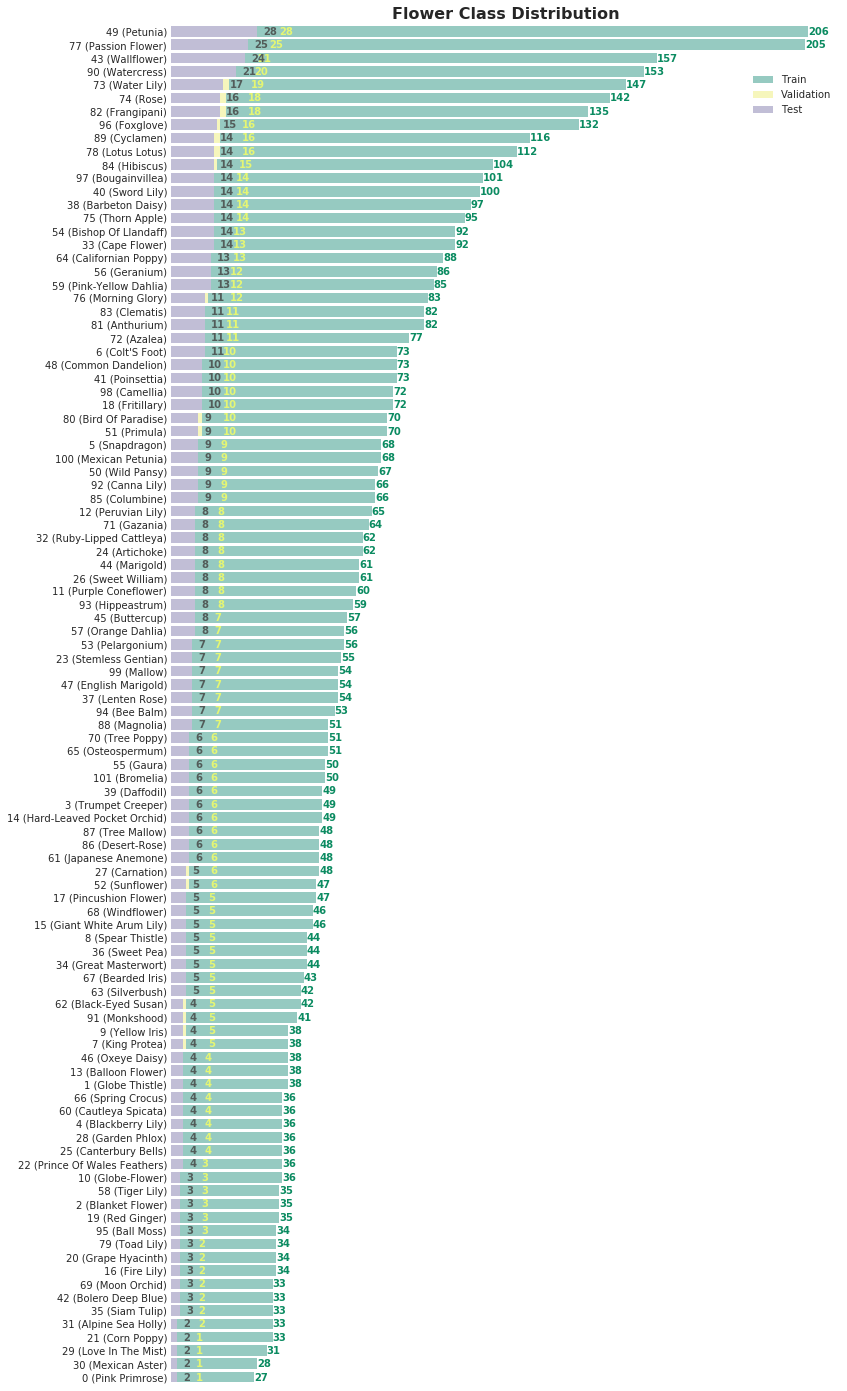

In [6]:
# Count the number of instances for each class in train, validation, and test datasets
train_class_counts = [len([sample for sample, class_idx in image_datasets['train'].samples if class_idx == idx]) for idx in range(num_classes)]
val_class_counts = [len([sample for sample, class_idx in image_datasets['val'].samples if class_idx == idx]) for idx in range(num_classes)]
test_class_counts = [len([sample for sample, class_idx in image_datasets['test'].samples if class_idx == idx]) for idx in range(num_classes)]

# Get the class labels from the class_to_idx mapping
class_labels = [f"{idx} ({cat_to_name[str(class_idx)].title()})" for idx, class_idx in enumerate(image_datasets['train'].class_to_idx)]

# Sort the class_counts and class_labels in descending order based on train_class_counts
train_class_counts, class_labels = zip(*sorted(zip(train_class_counts, class_labels), reverse=True))
val_class_counts, _ = zip(*sorted(zip(val_class_counts, class_labels), reverse=True))
test_class_counts, _ = zip(*sorted(zip(test_class_counts, class_labels), reverse=True))

# Create a DataFrame for the class distribution
data = {'Class': class_labels, 'Train Count': train_class_counts, 'Validation Count': val_class_counts, 'Test Count': test_class_counts}
df = pd.DataFrame(data)

# Set the color palette for the countplot
palette = sns.color_palette("Set3", 3)

# Plot a countplot using Seaborn
sns.set_style("white")
fig, ax = plt.subplots(figsize=(12, 25))
sns.barplot(y='Class', x='Train Count', data=df, color=palette[0], label='Train', ax=ax)
sns.barplot(y='Class', x='Validation Count', data=df, color=palette[1], label='Validation', ax=ax)
sns.barplot(y='Class', x='Test Count', data=df, color=palette[2], label='Test', ax=ax)

# Label for train dataset
for i, bar in enumerate(ax.patches):
    if i < len(train_class_counts):
        ax.text(bar.get_width(), bar.get_y() + bar.get_height() / 2, int(bar.get_width()),
                ha='left', va='center', color='#0B8B61', weight="bold")

# Label for validation dataset
for i, bar in enumerate(ax.patches):
    if len(train_class_counts) <= i < len(train_class_counts) + len(val_class_counts):
        ax.text(bar.get_width()+7, bar.get_y() + bar.get_height() / 2, int(bar.get_width()),
                ha='left', va='center', color='#E5F673', weight="bold")

# Label for test dataset        
for i, bar in enumerate(ax.patches):
    if len(train_class_counts) + len(val_class_counts) <= i < len(train_class_counts) + len(val_class_counts) + len(test_class_counts):
        ax.text(bar.get_width()+2, bar.get_y() + bar.get_height() / 2, int(bar.get_width()),
                ha='left', va='center', color='#525C59', weight="bold")

ax.set_title('Flower Class Distribution', fontsize=16, fontweight='bold')
ax.set_xlabel('')
ax.set_ylabel('')

sns.despine(top=True, right=True, left=True, bottom=True)

ax.legend(loc='upper right', bbox_to_anchor=(1, 0.97), frameon=False)
ax.set_xticklabels([])  # Hide x-axis tick labels

plt.show()

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

One last important tip if you're using the workspace to run your code: To avoid having your workspace disconnect during the long-running tasks in this notebook, please read in the earlier page in this lesson called Intro to
GPU Workspaces about Keeping Your Session Active. You'll want to include code from the workspace_utils.py module.

## Note for Workspace users: 
If your network is over 1 GB when saved as a checkpoint, there might be issues with saving backups in your workspace. Typically this happens with wide dense layers after the convolutional layers. If your saved checkpoint is larger than 1 GB (you can open a terminal and check with `ls -lh`), you should reduce the size of your hidden layers and train again.

In [13]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [9]:
# TODO: Build and train your network

# Prompt for selecting CNN architecture
architecture_prompt = "resnet"

# Define lists to track losses and accuracies
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Function to train the model
def train(model, optimizer, criterion, dataloader, device):
    model.train()
    train_loss = 0.0
    train_accuracy = 0.0

    for images, labels in dataloader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        train_accuracy += (predicted == labels).sum().item()

    train_loss = train_loss / len(dataloader.dataset)
    train_accuracy = train_accuracy / len(dataloader.dataset)

    return train_loss, train_accuracy

# Function to evaluate the model
def evaluate(model, criterion, dataloader, device):
    model.eval()
    loss = 0.0
    accuracy = 0.0

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss += criterion(outputs, labels).item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            accuracy += (predicted == labels).sum().item()

    loss = loss / len(dataloader.dataset)
    accuracy = accuracy / len(dataloader.dataset)

    return loss, accuracy

# Function to test the model
def test(model, criterion, dataloader, device):
    test_loss, test_accuracy = evaluate(model, criterion, dataloader, device)
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Function to create and train the model
def train_model(model_name, dataloaders):
    if model_name == "resnet":
        model = models.resnet50(pretrained=True)
        num_features = model.fc.in_features
        model.fc = nn.Linear(num_features, 102)  # Assuming 102 flower species
    else:
        print("Invalid model name!")
        return None

    model = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

    num_epochs = 10
    best_val_accuracy = 0.0

    for epoch in range(num_epochs):
        try:
            train_loss, train_accuracy = train(model, optimizer, criterion, dataloaders['train'], device)
            val_loss, val_accuracy = evaluate(model, criterion, dataloaders['val'], device)

            # Append losses and accuracies to the respective lists
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            train_accuracies.append(train_accuracy)
            val_accuracies.append(val_accuracy)

            print(f"Epoch {epoch+1}/{num_epochs}")
            print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
            print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

            if val_accuracy > best_val_accuracy:
                best_val_accuracy = val_accuracy

        except Exception as e:
            print(f"An error occurred during training: {e}")
            break

    test(model, criterion, dataloaders['test'], device)

    return model, optimizer, num_epochs, train_losses, val_losses, train_accuracies, val_accuracies

# TODO: Do validation on the test set

# Train and test the specified model
print(f"Training and testing {architecture_prompt} model:")
trained_model = train_model(architecture_prompt, dataloaders)

Training and testing resnet model:
Epoch 1/10
Train Loss: 3.2845, Train Accuracy: 0.3336
Val Loss: 1.7957, Val Accuracy: 0.6357
Epoch 2/10
Train Loss: 1.2763, Train Accuracy: 0.7911
Val Loss: 0.7006, Val Accuracy: 0.8704
Epoch 3/10
Train Loss: 0.5384, Train Accuracy: 0.9342
Val Loss: 0.3601, Val Accuracy: 0.9242
Epoch 4/10
Train Loss: 0.2687, Train Accuracy: 0.9719
Val Loss: 0.2287, Val Accuracy: 0.9425
Epoch 5/10
Train Loss: 0.1589, Train Accuracy: 0.9855
Val Loss: 0.1919, Val Accuracy: 0.9487
Epoch 6/10
Train Loss: 0.1077, Train Accuracy: 0.9896
Val Loss: 0.1648, Val Accuracy: 0.9511
Epoch 7/10
Train Loss: 0.0721, Train Accuracy: 0.9937
Val Loss: 0.1488, Val Accuracy: 0.9535
Epoch 8/10
Train Loss: 0.0554, Train Accuracy: 0.9944
Val Loss: 0.1336, Val Accuracy: 0.9523
Epoch 9/10
Train Loss: 0.0442, Train Accuracy: 0.9954
Val Loss: 0.1250, Val Accuracy: 0.9511
Epoch 10/10
Train Loss: 0.0342, Train Accuracy: 0.9956
Val Loss: 0.1246, Val Accuracy: 0.9560
Test Loss: 0.1300, Test Accuracy: 

In [17]:
### Set Up Again for Optimizer
model = models.resnet50(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 102)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

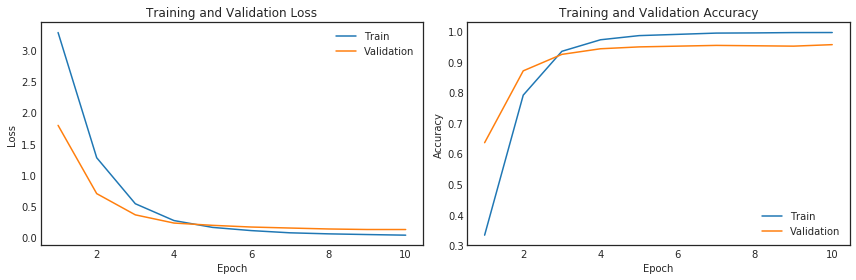

In [16]:
# Plot the loss and accuracy curves
num_epochs=10
def plot_loss_accuracy(num_epochs, train_losses, val_losses, train_accuracies, val_accuracies):
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs+1), train_losses, label='Train')
    plt.plot(range(1, num_epochs+1), val_losses, label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs+1), train_accuracies, label='Train')
    plt.plot(range(1, num_epochs+1), val_accuracies, label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call the function to plot the loss and accuracy curves
plot_loss_accuracy(num_epochs, train_losses, val_losses, train_accuracies, val_accuracies)

## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [20]:
# TODO: Save the checkpoint 

# Save the model checkpoint
checkpoint = {
    'model_state_dict': trained_model[0].state_dict(),
    'optimizer_state_dict': trained_model[1].state_dict(),
    'class_to_idx': dataloaders['train'].dataset.class_to_idx
}

# Attach class_to_idx mapping to the model
trained_model[0].class_to_idx = dataloaders['train'].dataset.class_to_idx

# Save the checkpoint to a file
torch.save(checkpoint, f"{architecture_prompt}_best_model.pt")

## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [14]:
# TODO: Write a function that loads a checkpoint and rebuilds the model
def load_checkpoint(filepath):
    # Load the checkpoint from file
    checkpoint = torch.load(filepath)

    # Rebuild the model architecture
    model = models.resnet50(pretrained=True)
    num_features = model.fc.in_features
    model.fc = nn.Linear(num_features, len(checkpoint['class_to_idx']))

    # Load the trained model state_dict
    model.load_state_dict(checkpoint['model_state_dict'])

    # Attach class_to_idx mapping to the model
    model.class_to_idx = checkpoint['class_to_idx']

    return model

# Load the model from the checkpoint
loaded_model = load_checkpoint('resnet_best_model.pt')
loaded_model

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.torch/models/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:01<00:00, 74486586.97it/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [35]:
from PIL import Image

def process_image(image_path):
    # Open the image using PIL
    image = Image.open(image_path)

    # Resize the image
    image.thumbnail((256, 256))

    # Crop the center portion of the image
    width, height = image.size
    left = (width - 224) / 2
    top = (height - 224) / 2
    right = (width + 224) / 2
    bottom = (height + 224) / 2
    image = image.crop((left, top, right, bottom))

    # Convert image to numpy array
    np_image = np.array(image)

    # Normalize the image
    np_image = np_image / 255.0
    np_image = (np_image - [0.485, 0.456, 0.406]) / [0.229, 0.224, 0.225]

    # Transpose the image to match PyTorch format
    np_image = np_image.transpose((2, 0, 1))

    # Convert the numpy array to a PyTorch tensor
    image_tensor = torch.from_numpy(np_image).float()

    return image_tensor

To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [36]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor or PIL Image."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # Convert the image to a NumPy array
    if isinstance(image, Image.Image):
        image = np.array(image)
    
    # Check if the image is a tensor
    if torch.is_tensor(image):
        image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Clip the image between 0 and 1
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    ax.axis('off')
    
    if title:
        ax.set_title(title)
    
    return ax

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [37]:
# Perform inference and return the top K most likely classes
def predict(image_path, model, topk=5):
    image = process_image(image_path)
    image = image.unsqueeze(0)
    image = image.to(device)

    model.eval()
    with torch.no_grad():
        output = model(image)

    probabilities = torch.nn.functional.softmax(output, dim=1)[0]
    top_probs, top_indices = probabilities.topk(topk)
    top_probs = top_probs.cpu().numpy().tolist()
    top_indices = top_indices.cpu().numpy().tolist()
    top_classes = [class_labels[idx] for idx in top_indices]

    return top_probs, top_classes

## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

In [253]:
# TODO: Display an image along with the top 5 classes

def get_random_image(data_dir):
    # Get the path to the test directory
    test_dir = os.path.join(data_dir, 'test')

    # Get a random flower class directory
    class_dir = random.choice(os.listdir(test_dir))

    # Get the path to the random flower class directory
    class_path = os.path.join(test_dir, class_dir)

    # Get a random image file from the flower class directory
    image_file = random.choice(os.listdir(class_path))

    # Return the path to the random image
    return os.path.join(class_path, image_file)

def plot_prediction(loaded_model, class_labels, topk=5):
    # Create subplots with 3 rows and 2 columns
    fig, axes = plt.subplots(3, 2, figsize=(10, 10))
    fig.subplots_adjust(wspace=0.5, hspace=0.5)

    for ax_row in axes:
        # Get a random image path from the data directory
        image_path = get_random_image(data_dir)

        # Make a prediction
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        loaded_model = loaded_model.to(device)
        loaded_model.eval()

        image = process_image(image_path)
        image = image.unsqueeze(0)
        image = image.to(device)

        with torch.no_grad():
            output = loaded_model(image)

        probabilities = torch.nn.functional.softmax(output, dim=1)[0]
        top_probs, top_indices = probabilities.topk(topk)
        top_probs = top_probs.cpu().numpy().tolist()
        top_indices = top_indices.cpu().numpy().tolist()
        top_classes = [class_labels[idx] for idx in top_indices]

        # Sort the probabilities and class labels in descending order
        sorted_indices = np.argsort(top_probs)[::-1]
        sorted_probs = [top_probs[idx] for idx in sorted_indices]
        sorted_classes = [top_classes[idx] for idx in sorted_indices]

        # Load the input image
        image = Image.open(image_path)

        # Display the image using imshow
        ax_row[0].imshow(image)
        ax_row[0].axis('off')

        # Set the title of the image
        flower_name = class_labels[top_indices[0]]
        ax_row[0].set_title(flower_name)

        # Define the color palette
        palette = sns.color_palette("viridis", len(sorted_probs))
        palette.reverse()

        # Plot the probabilities as a bar graph using seaborn
        sns.barplot(x=sorted_probs, y=sorted_classes, ax=ax_row[1], palette=palette)

        # Set the x and y labels
        ax_row[1].set_xlabel('Probability')
        ax_row[1].set_ylabel('')
        ax_row[1].set_title('Top 5 Predictions')

    plt.tight_layout()
    plt.show()

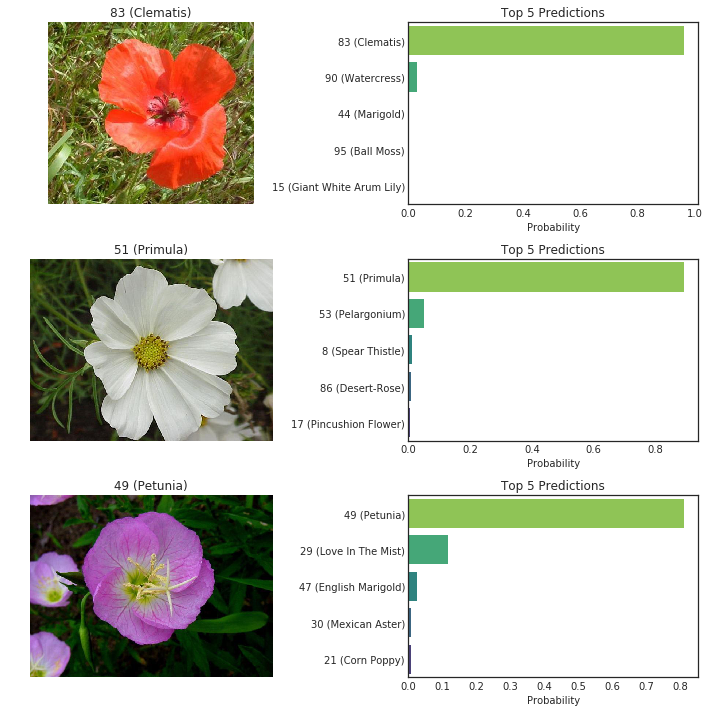

In [265]:
plot_prediction(loaded_model, class_labels)

## Reminder for Workspace users
If your network becomes very large when saved as a checkpoint, there might be issues with saving backups in your workspace. You should reduce the size of your hidden layers and train again. 
    
We strongly encourage you to delete these large interim files and directories before navigating to another page or closing the browser tab.

In [266]:
# TODO remove .pth files or move it to a temporary `~/opt` directory in this 
import shutil
import os

# Define the source and destination paths
source_path = "resnet_best_model.pt"
destination_path = "/root/opt/resnet_best_model.pt"

# Create the destination directory if it doesn't exist
os.makedirs(os.path.dirname(destination_path), exist_ok=True)

# Move the file to the destination directory
shutil.move(source_path, destination_path)

# Verify the file move
if os.path.exists(destination_path):
    print("File moved successfully to ~/opt directory.")
else:
    print("Failed to move the file.")

File moved successfully to ~/opt directory.
